In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sunRay.parameters import c,c_r,R_S  # physics parameters
from scipy import integrate



In [2]:
data  = np.load('sunray_big_float32_20deg.npz')

In [3]:
absorb_r = (np.count_nonzero((np.isnan(data.f.r_vec_collect_local[-1,1,:]))))/data.f.photon_N

In [4]:
# retrive the data from archive
steps_N  =data.f.steps_N
collect_N =data.f.collect_N
photon_N =data.f.photon_N
start_r =data.f.start_r
start_theta =data.f.start_theta
start_phi  =data.f.start_phi
f_ratio  =data.f.f_ratio
epsilon =data.f.epsilon 
anis =data.f.anis
asym =data.f.asym
omega0 = data.f.omega0
freq0 = data.f.freq0
t_collect=data.f.t_collect
tau=data.f.tau
r_vec_collect_local=data.f.r_vec_collect_local
k_vec_collect_local=data.f.k_vec_collect_local

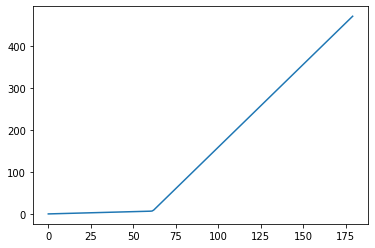

In [5]:
plt.plot(t_collect)

In [6]:
absorb_r

0.269757

In [7]:
find_small_1e3 = lambda arr:  np.sort(arr)[int(photon_N*1e-3)]

In [8]:
# collect the photons
r_vec_end = r_vec_collect_local[-1,:,:].reshape(3,-1)
k_vec_end = k_vec_collect_local[-1,:,:].reshape(3,-1)
rr_end = np.sqrt(np.sum(r_vec_end**2,axis=0))
kk_end = np.sqrt(np.sum(k_vec_end**2,axis=0))

kx_end,ky_end,kz_end = k_vec_end[0,:],k_vec_end[1,:],k_vec_end[2,:]



In [9]:
# use the majority photons
r_get = find_small_1e3(rr_end)
 

In [10]:
r_vec_end.shape

(3, 1000000)

In [11]:
# fit to find t and x_im y_im

In [12]:
# histogram

In [13]:
R_S = 6.96e10         # the radius of the sun 
c   = 2.998e10        # speed of light
c_r = c/R_S           # [t]


In [14]:
idx_for_stat = np.where( (rr_end>(r_get-0.1)) & 
                         (kz_end/kk_end>0.9) & 
                         (kz_end/kk_end<1.0) )

In [15]:
x_im_stat = np.zeros(idx_for_stat[0].shape)
y_im_stat = np.zeros(idx_for_stat[0].shape)
t_reach_stat = np.zeros(idx_for_stat[0].shape)
tau_stat = np.zeros(idx_for_stat[0].shape)


idx_tmp = 0
for idx_cur in idx_for_stat[0]:
    # for all rays do the collect:
    r_vec_tmp = r_vec_collect_local[:,:,idx_cur]
    rr_tmp = np.sqrt(np.sum(r_vec_tmp**2,axis=1))
    idx_r_reach = np.argmin(np.abs(rr_tmp-r_get))
    # linear estimation of the [t,r,k] at r_get
    t_reach_tmp = (t_collect[idx_r_reach-1] + 
        (t_collect[idx_r_reach]-t_collect[idx_r_reach-1]) *
        (r_get-rr_tmp[idx_r_reach-1]) /
        (rr_tmp[idx_r_reach]-rr_tmp[idx_r_reach-1]) )

    r_vec_reach_tmp = (r_vec_collect_local[idx_r_reach-1,:,idx_cur] + 
        (r_vec_collect_local[idx_r_reach,:,idx_cur]-
         r_vec_collect_local[idx_r_reach-1,:,idx_cur]) *
        (r_get-rr_tmp[idx_r_reach-1]) /
        (rr_tmp[idx_r_reach]-rr_tmp[idx_r_reach-1]) )

    k_vec_reach_tmp = (k_vec_collect_local[idx_r_reach-1,:,idx_cur] + 
        (k_vec_collect_local[idx_r_reach,:,idx_cur]-
         k_vec_collect_local[idx_r_reach-1,:,idx_cur]) *
        (r_get-rr_tmp[idx_r_reach-1]) /
        (rr_tmp[idx_r_reach]-rr_tmp[idx_r_reach-1]) )

    t_reach_stat[idx_tmp] = t_reach_tmp

    kk_tmp = np.sqrt(np.sum(k_vec_reach_tmp**2))
    kx_tmp = k_vec_reach_tmp[0]
    ky_tmp = k_vec_reach_tmp[1]
    kz_tmp = k_vec_reach_tmp[2]

    # use Delta R as free path integral
    r_free_tmp_a = np.sqrt(np.sum((r_vec_reach_tmp - r_vec_collect_local[0,:,idx_cur])**2))
    # use t*c as free path integral
    r_free_tmp_b = t_reach_tmp*c_r

    x_im_stat[idx_tmp] = r_vec_reach_tmp[0] - r_free_tmp_a*kx_tmp/kk_tmp
    y_im_stat[idx_tmp] = r_vec_reach_tmp[1] - r_free_tmp_a*ky_tmp/kk_tmp

    
    tau_stat[idx_tmp] = tau[idx_cur]

    idx_tmp = idx_tmp+1    

weights_stat = np.exp(-tau_stat)

In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
from sunRay import plasmaFreq as pfreq
from sunRay import densityModel as dm
ne_r = dm.parkerfit   # use leblanc for this calculation 
#freq0 = 35.045e6
#omega0 = 2*np.pi*freq0
t_delay = integrate.quad(lambda x: (1/(c_r*np.sqrt(1.0-pfreq.omega_pe_r_np(dm.leblanc98,x)/omega0)) ) ,r_get,215 )[0]
t_reach_1au_stat = t_reach_stat + t_delay

In [18]:
r_vec_tmp[0,:]

array([ 5.9854692e-01, -1.5263782e-05,  1.6445522e+00], dtype=float32)

131.15829111923117


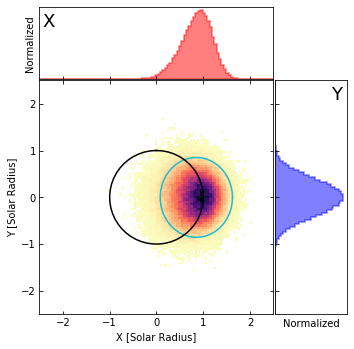

In [87]:
#hst = plt.hist2d(x_im_stat,y_im_stat,bins=[np.linspace(-2,2,100),np.linspace(-2,2,100)],weights=np.exp(-tau_stat))
#plt.axis('equal')


from sunRay.showPlot import XYDistributionImageHist

XYDistributionImageHist(x_im_stat,y_im_stat,bins_data=np.linspace(-2.5,2.5,100)
            ,weights_data=np.exp(-tau_stat))

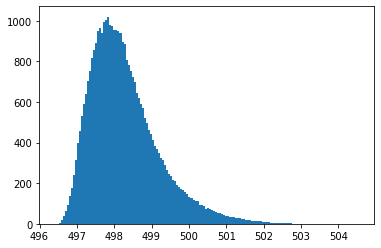

In [63]:
hst = plt.hist(t_reach_1au_stat,150,weights=np.exp(-tau_stat))

In [27]:

lower_t_lim = np.sort(t_reach_1au_stat)[int(t_reach_1au_stat.shape[0]*2e-3)]
upper_t_lim = np.sort(t_reach_1au_stat)[int(t_reach_1au_stat.shape[0]*(1-0.1))]

num_t_bins = int((upper_t_lim-lower_t_lim)/0.05)
t_bins = np.linspace(lower_t_lim,upper_t_lim,num_t_bins)

t_bin_center = (t_bins[0:-1]+t_bins[1:])/2

xc = np.zeros(t_bin_center.shape)
yc = np.zeros(t_bin_center.shape)
sx = np.zeros(t_bin_center.shape)
sy = np.zeros(t_bin_center.shape)

idx_cur = 0
for idx_t_bin in np.arange(len(t_bin_center)):
    idx_in_t_range = np.where((t_reach_1au_stat>t_bins[idx_t_bin]) 
                            & (t_reach_1au_stat<t_bins[idx_t_bin+1]))
    
    x_im_in_t_range = x_im_stat[idx_in_t_range]
    y_im_in_t_range = y_im_stat[idx_in_t_range]
    weights_in_t_range = weights_stat[idx_in_t_range]

    xc[idx_cur] = (np.mean(x_im_in_t_range*weights_in_t_range) / 
                    np.mean(weights_in_t_range))
    yc[idx_cur] = (np.mean(y_im_in_t_range*weights_in_t_range) / 
                    np.mean(weights_in_t_range))
    
    sx[idx_cur]=np.sqrt(np.mean(weights_in_t_range*(x_im_in_t_range-xc[idx_cur])**2)/
                np.mean(weights_in_t_range))*2.355
    sy[idx_cur]=np.sqrt(np.mean(weights_in_t_range*(y_im_in_t_range-yc[idx_cur])**2)/
                np.mean(weights_in_t_range))*2.355
    
    idx_cur = idx_cur + 1



In [55]:



plt.errorbar(t_bin_center,xc,drawstyle)
plt.errorbar(t_bin_center,yc)

(5838,)

In [145]:
print(hst[0][20,:])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.22065742e-01 0.00000000e+00 4.40566029e-01 1.70077755e+00
 1.70748397e+00 6.95538646e+00 5.89382475e+00 9.85790884e+00
 1.26816283e+01 2.18808190e+01 2.89920703e+01 4.33193431e+01
 6.20829333e+01 6.96648978e+01 8.87157899e+01 8.75351301e+01
 1.02120347e+02 1.11840275e+02 1.07779498e+02 1.13492928e+02
 1.17933382e+02 1.16222340e+02 1.07980399e+02 9.12755591e+01
 8.95812356e+01 8.26491111e+01 7.54039651e+01 5.97456903e+01
 4.14483934e+01 3.11447867e+01 2.23753065e+01 1.72361751e+01
 1.14423529e+01 2.51488231e+00 1.75856313e+00 1.58451947e+00
 4.89390125e-01 7.68808850e-01 2.72333048e-01 0.00000000e+00
 1.13675706e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.60123366e-01 0.00000000e+00]


In [88]:
x_im_stat.shape
# finish time diff based 
# fit guassian

(217062,)